<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/%E5%AD%A3%E7%AF%80%E5%A4%89%E5%8B%95%E3%81%AE%E3%81%82%E3%82%8B%E6%99%82%E7%B3%BB%E5%88%97%E3%81%8B%E3%82%89%E3%81%AE%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

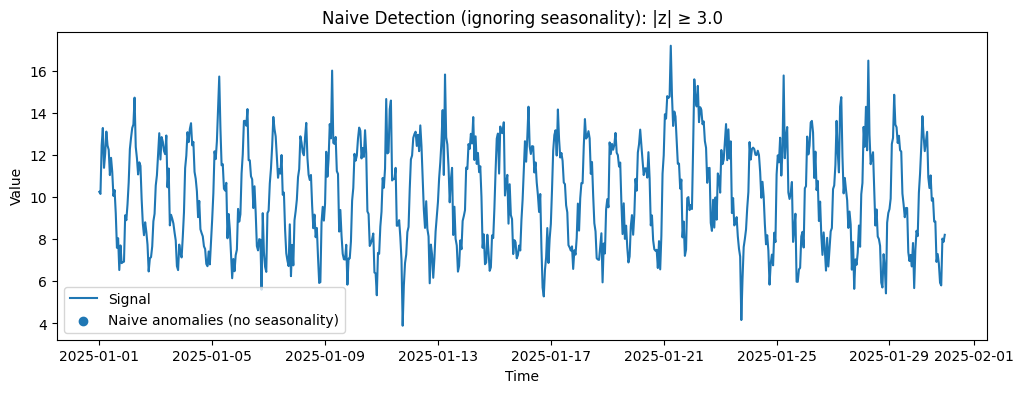

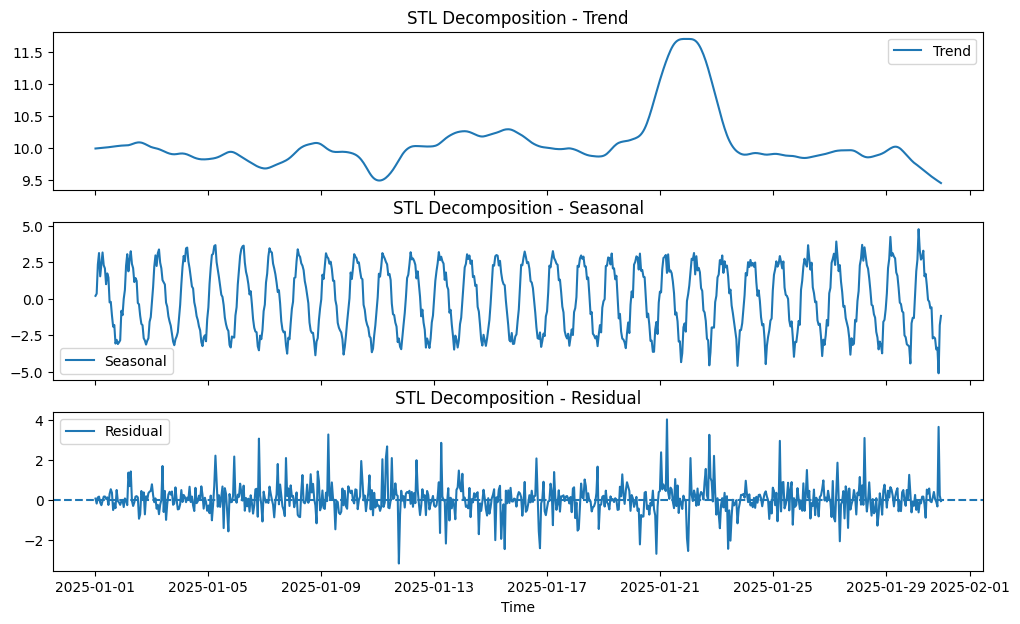

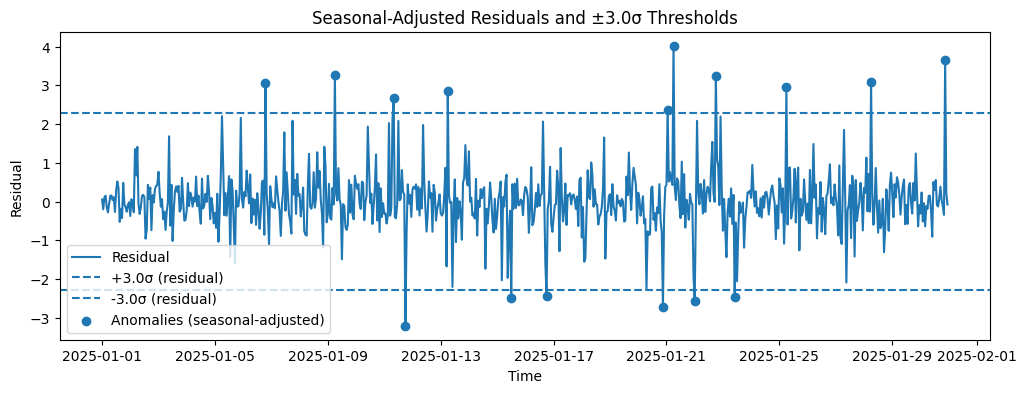

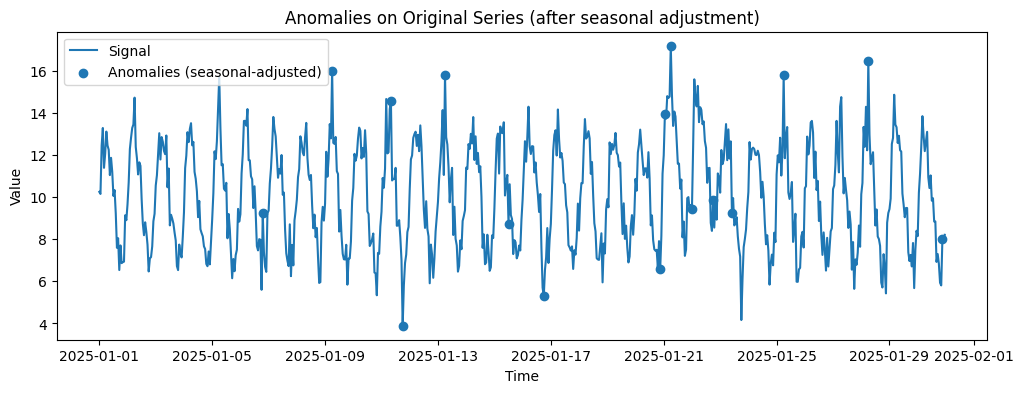

[Naive] Detected anomalies: 0 / 720
[Seasonal-adjusted] Detected anomalies: 16 / 720
Saved: series/trend/seasonal/residual/anomalies_naive/anomalies_seasonal_adjusted CSVs


In [1]:
# Colab-ready: Anomaly detection on seasonal time series
# - "Naive" detection (ignoring seasonality) fails
# - Seasonal adjustment via STL succeeds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# (Colab usually has statsmodels. If not, uncomment the next line)
# !pip -q install statsmodels
from statsmodels.tsa.seasonal import STL

# ===== Parameters =====
N = 24 * 30            # 30 days of hourly data
PERIOD = 24            # daily seasonality (hours)
SEED = 42              # RNG seed
A = 3.0                # seasonal amplitude
NOISE_SIGMA = 0.8      # observation noise std
K = 3.0                # z-threshold

# ===== 0) Generate seasonal time series with planted anomalies =====
rng = np.random.default_rng(SEED)
t = np.arange(N)
# Base + seasonal + noise
y = 10 + A*np.sin(2*np.pi*t/PERIOD) + 0.4*np.sin(4*np.pi*t/PERIOD) + rng.normal(0, NOISE_SIGMA, size=N)

# Inject anomalies aligned with seasonal peaks/troughs (hard to catch without seasonal adjustment)
anomaly_idx_pos = [6 + PERIOD*d for d in [4, 8, 12, 16, 20, 24, 27]]     # near daily peak
anomaly_idx_neg = [18 + PERIOD*d for d in [5, 10, 15, 22, 26]]           # near daily trough
for i in anomaly_idx_pos:
    if i < N: y[i] += 3.0    # positive spikes
for i in anomaly_idx_neg:
    if i < N: y[i] -= 3.0    # negative spikes
# short level shift segment during high season
y[24*20:24*22] += 1.8

# Optional time index (hourly)
time_index = pd.date_range("2025-01-01", periods=N, freq="h")
s = pd.Series(y, index=time_index, name="value")

# ===== 1) Naive (non-seasonal) z-score detection =====
z_naive = (s - s.mean()) / s.std(ddof=0)
naive_mask = z_naive.abs() >= K

# ===== 2) Seasonal adjustment with STL, then detect on residuals =====
stl = STL(s, period=PERIOD, robust=True)
res = stl.fit()
trend, seasonal, resid = res.trend, res.seasonal, res.resid

z_resid = resid / resid.std(ddof=0)
seasonal_mask = z_resid.abs() >= K

# ===== 3) Plots =====

# Figure 1: Raw series and anomalies flagged by NAIVE method (likely few/none)
plt.figure(figsize=(12, 4))
plt.plot(s.index, s.values, label="Signal")
plt.scatter(s.index[naive_mask], s.values[naive_mask], marker="o", label="Naive anomalies (no seasonality)")
plt.title(f"Naive Detection (ignoring seasonality): |z| ≥ {K}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(loc="best")
plt.show()

# Figure 2: STL decomposition (trend / seasonal / residual)
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
axes[0].plot(trend.index, trend.values, label="Trend")
axes[0].set_title("STL Decomposition - Trend")
axes[0].legend(loc="best")

axes[1].plot(seasonal.index, seasonal.values, label="Seasonal")
axes[1].set_title("STL Decomposition - Seasonal")
axes[1].legend(loc="best")

axes[2].plot(resid.index, resid.values, label="Residual")
axes[2].axhline(0, linestyle="--")
axes[2].set_title("STL Decomposition - Residual")
axes[2].legend(loc="best")
plt.xlabel("Time")
plt.show()

# Figure 3: Residual with ±kσ thresholds and seasonal-adjusted anomalies
sigma_resid = resid.std(ddof=0)
plt.figure(figsize=(12, 4))
plt.plot(resid.index, resid.values, label="Residual")
plt.axhline( K*sigma_resid, linestyle="--", label=f"+{K}σ (residual)")
plt.axhline(-K*sigma_resid, linestyle="--", label=f"-{K}σ (residual)")
plt.scatter(resid.index[seasonal_mask], resid.values[seasonal_mask], marker="o",
            label="Anomalies (seasonal-adjusted)")
plt.title(f"Seasonal-Adjusted Residuals and ±{K}σ Thresholds")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.legend(loc="best")
plt.show()

# Figure 4: Original series with anomalies flagged by seasonal-adjusted detection
plt.figure(figsize=(12, 4))
plt.plot(s.index, s.values, label="Signal")
plt.scatter(s.index[seasonal_mask], s.values[seasonal_mask], marker="o",
            label="Anomalies (seasonal-adjusted)")
plt.title("Anomalies on Original Series (after seasonal adjustment)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(loc="best")
plt.show()

# ===== 4) Summary & CSV =====
naive_anoms = pd.DataFrame({"time": s.index[naive_mask], "value": s[naive_mask].values})
seasonal_anoms = pd.DataFrame({"time": s.index[seasonal_mask], "value": s[seasonal_mask].values,
                               "z_resid": z_resid[seasonal_mask].values})

print(f"[Naive] Detected anomalies: {naive_mask.sum()} / {len(s)}")
print(f"[Seasonal-adjusted] Detected anomalies: {seasonal_mask.sum()} / {len(s)}")

# Save CSVs
s.to_csv("series.csv", header=True)
trend.rename("trend").to_csv("trend.csv", header=True)
seasonal.rename("seasonal").to_csv("seasonal.csv", header=True)
resid.rename("residual").to_csv("residual.csv", header=True)
naive_anoms.to_csv("anomalies_naive.csv", index=False)
seasonal_anoms.to_csv("anomalies_seasonal_adjusted.csv", index=False)
print("Saved: series/trend/seasonal/residual/anomalies_naive/anomalies_seasonal_adjusted CSVs")
